In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, \
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips, \
                            load_sim_dir

In [2]:
sim_dirs = """
testing_fraction_fall_testing.1589953130.91
severe_self_reporting_fall_testing.1589953013.14
prevalence_fall_testing.1589952986.07
mild_self_reporting_fall_testing.1589952961.69
exposed_infection_p_fall_testing.1589952935.91
daily_contacts_fall.1589952910.77
contact_recall_fall_testing.1589952888.31
contact_delay_fall_testing.1589952860.61
severe_self_reporting_fall.1589952834.98
prevalence_fall.1589952816.44
mild_self_reporting_fall.1589952799.58
exposed_infection_p_fall.1589952779.6
daily_contacts_fall.1589952759.95
contact_recall_fall.1589952747.16
contact_delay_fall.1589952707.35
severe_self_reporting_base.1589952668.59
prevalence_base.1589952642.83
mild_self_reporting_base.1589952629.81
exposed_infection_p_base.1589952615.17
daily_contacts_base.1589952590.84
contact_recall_base.1589952578.93
contact_delay_base.1589952562.03""".split('\n')

fall_sim_results = {}
base_sim_results = {}
fall_testing_results = {}

unallocated_results = []

for folder in sim_dirs:
    sims_in_dir = load_sim_dir("/nfs01/covid_sims/" + folder, verbose=False)
    print("Done loading {}".format(folder))
    if '_base' in folder:
        param_name = folder.split('_base')[0]
        base_sim_results[param_name] = sims_in_dir
    elif '_fall_testing' in folder:
        param_name = folder.split('_fall_testing')[0]
        fall_testing_results[param_name] = sims_in_dir
    elif '_fall' in folder:
        param_name = folder.split('_fall')[0]
        fall_sim_results[param_name] = sims_in_dir
    else:
        print("couldn't determinie fall or base")
        unallocated_results.append(sims_in_dir)
        
fall_testing_results['daily_contacts'] = load_sim_dir("/nfs01/covid_sims/daily_contacts_fall.1589952910.77")

Done loading 
couldn't determinie fall or base
Done loading testing_fraction_fall_testing.1589953130.91
Done loading severe_self_reporting_fall_testing.1589953013.14
Done loading prevalence_fall_testing.1589952986.07
Done loading mild_self_reporting_fall_testing.1589952961.69
Done loading exposed_infection_p_fall_testing.1589952935.91
Done loading daily_contacts_fall.1589952910.77
Done loading contact_recall_fall_testing.1589952888.31
Done loading contact_delay_fall_testing.1589952860.61
Done loading severe_self_reporting_fall.1589952834.98
Done loading prevalence_fall.1589952816.44
Done loading mild_self_reporting_fall.1589952799.58
Done loading exposed_infection_p_fall.1589952779.6
Done loading daily_contacts_fall.1589952759.95
Done loading contact_recall_fall.1589952747.16
Done loading contact_delay_fall.1589952707.35
Done loading severe_self_reporting_base.1589952668.59
Done loading prevalence_base.1589952642.83
Done loading mild_self_reporting_base.1589952629.81
Done loading expos

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
def extract_severities(dfs):
    severities = []
    for df in dfs:
        all_cols = set(df.columns)
        new_cols = set(['cumulative_mild', 
                        'cumulative_severe', 
                        'severity_0', 
                        'severity_1', 
                        'severity_2', 
                        'severity_3'])
        main_cols = all_cols - new_cols
        subdf = df[list(main_cols)]
        popsize = sum(subdf.iloc[0])
        
        subdf = df[['severity_2', 'severity_3']]
        severe = sum(subdf.iloc[subdf.shape[0]-1])
        
        severities.append(100 * severe / popsize)
    return severities
def average_cumulative_severe(dfs):
    severities = []
    for df in dfs:
        all_cols = set(df.columns)
        new_cols = set(['cumulative_mild', 
                        'cumulative_severe', 
                        'severity_0', 
                        'severity_1', 
                        'severity_2', 
                        'severity_3'])
        main_cols = all_cols - new_cols
        subdf = df[list(main_cols)]
        popsize = sum(subdf.iloc[0])
        
        subdf = df[['severity_2', 'severity_3']]
        severe = sum(subdf.iloc[subdf.shape[0]-1])
        
        severities.append(100 * severe / popsize)
    return np.mean(severities)

def avg_cum_severe_quantile(dfs, q_low, q_high):
    severities = extract_severities(dfs)
    return np.quantile(severities, q_low), np.mean(severities), np.quantile(severities, q_high)

def cum_severe_quantiles(dfs, q_low, q_high):
    severities = extract_severities(dfs)
    return np.quantile(severities, q_low), np.quantile(severities, 0.5), np.quantile(severities, q_high)

def plot_many_dfs(sim_output_dict, yaxisfn, ylabel="", xlabel="", title="", figsize=(10,6)):
    plt.figure(figsize=figsize)
    for sim_label, sim_output in sim_output_dict.items():
        xs = []
        ys = []
        for sim_parameter_name, dfs in sim_output.items():
            # compute x-value assuming that sim_param_name is of form 'varied_param_name.value'
            param_val = float('.'.join(sim_parameter_name.split('.')[1:]))
            xs.append(param_val)
            # yaxisfn is a function that takes in a list of trajectory dataframes and
            # produces an output metric
            ys.append(yaxisfn(dfs))
        plt.plot(xs, ys, marker='o', label=sim_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()


def truncate(val, y_min, y_max):
    return max(min(val, y_max), y_min)
    
def plot_many_dfs_quantiles(sim_output_dict, yaxisfn, normalize_x_axis, x_log_scale=False, 
                            y_log_scale=False,
                            q_low=0.05, q_high=0.95, 
                            y_min = 0, y_max = 5,
                            ylabel="", xlabel="", title="", figsize=(10,6), alpha=0.1):
    # assn: yaxisfn(dfs) returns a tuple (q_low_val, avg, q_high_val)
    epsilon=1e-6
    plt.figure(figsize=figsize)
    if x_log_scale:
        plt.xscale("log")
    
    for sim_label, sim_output in sim_output_dict.items():
        xs = []
        ys = []
        q_low_vals = []
        q_high_vals = []
        for sim_parameter_name, dfs in sim_output.items():
            # compute x-value assuming that sim_param_name is of form 'varied_param_name.value'
            param_val = float('.'.join(sim_parameter_name.split('.')[1:]))
            if normalize_x_axis:
                xs.append(param_val * 100)
            else:
                xs.append(param_val)
            # yaxisfn is a function that takes in a list of trajectory dataframes and
            # produces an output metric
            q_low_val, avg, q_high_val = yaxisfn(dfs, q_low, q_high)
            if not y_log_scale:
                ys.append(truncate(avg, y_min, y_max))
                q_low_vals.append(truncate(q_low_val, y_min, y_max))
                q_high_vals.append(truncate(q_high_val, y_min, y_max))
            else:
                ys.append(avg + epsilon)
                q_low_vals.append(q_low_val + epsilon)
                q_high_vals.append(q_high_val + epsilon)
        plt.plot(xs, ys, marker='o', label=sim_label)
        plt.fill_between(xs, q_low_vals, q_high_vals, alpha=alpha)
    if y_log_scale:
        plt.yscale("log")
        plt.ylim(bottom=1e-2)
    else:
        plt.ylim(y_min, y_max)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

In [12]:
list(fall_sim_results.keys())

['daily_contacts',
 'severe_self_reporting',
 'prevalence',
 'mild_self_reporting',
 'exposed_infection_p',
 'contact_recall',
 'contact_delay']

In [17]:
plot_labels = {
    'daily_contacts': 'Average Contacts per Person per Day',
    'severe_self_reporting': 'Daily Symptomatic Self-Reporting Likelihood',
    'prevalence': 'Initial Prevalence (% of Total Population)',
    'mild_self_reporting': 'Daily Asymptomatic Self-Reporting Likelihood',
    'exposed_infection_p': 'Transmission Likelihood per Contact',
    'contact_recall': 'Percentage of Contacts Recalled in Contact Trace',
    'contact_delay': 'Contact Trace Delay (Days)'
}

normalize_params = {
    'daily_contacts': False,
    'severe_self_reporting': True,
    'prevalence': True,
    'mild_self_reporting': True,
    'exposed_infection_p': True,
    'contact_recall': True,
    'contact_delay': False
}

plot_log_scale = {
    'daily_contacts': False,
    'severe_self_reporting': False,
    'prevalence': True,
    'mild_self_reporting': False,
    'exposed_infection_p': False,
    'contact_recall': False,
    'contact_delay': False    
}

In [52]:
cum_severe_quantiles(base_sim_results['prevalence']['initial_ID_prevalence.0.0001'], 0.05, 0.95)

(0.0, 0.0, 0.043434468269449)

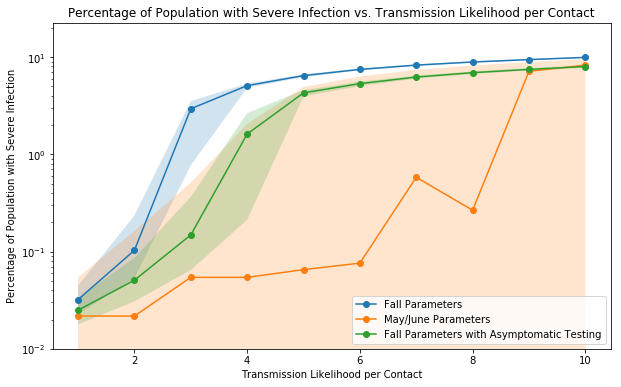

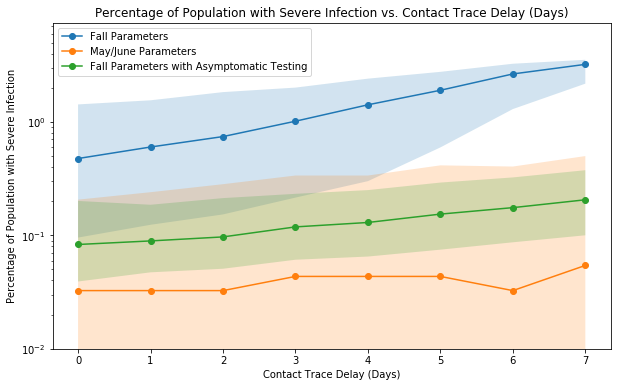

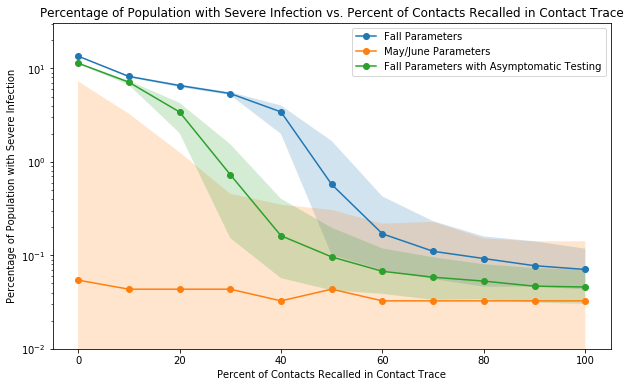

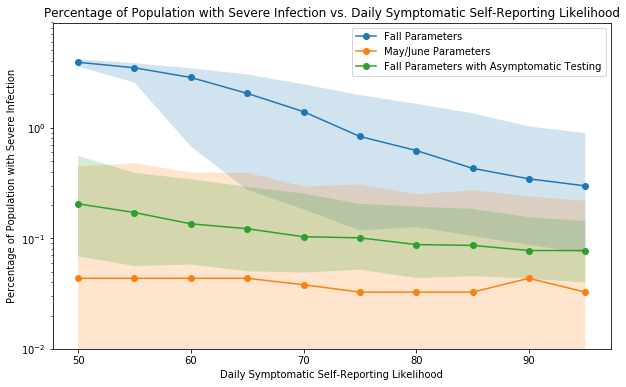

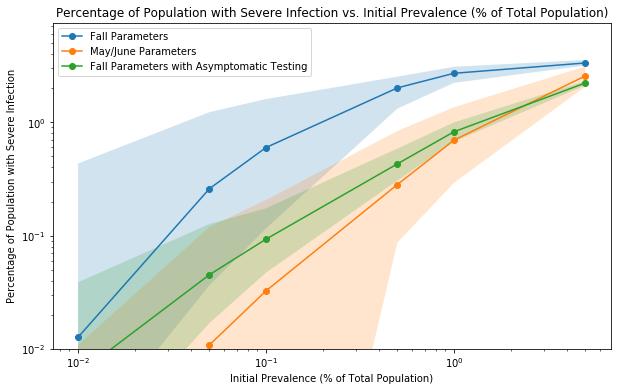

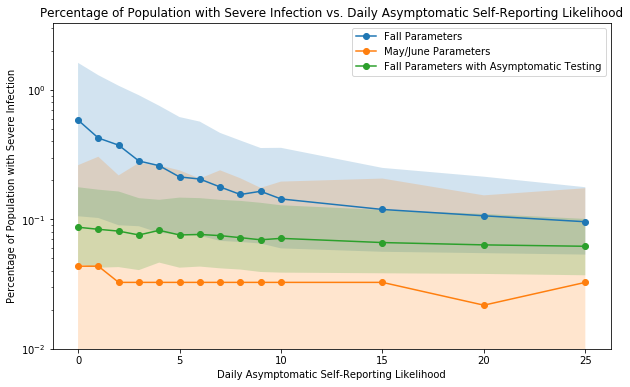

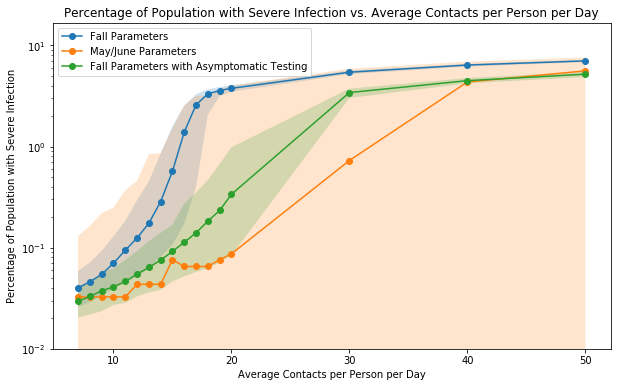

In [61]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs_quantiles({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, cum_severe_quantiles,
                            normalize_params[sim_name], x_log_scale=plot_log_scale[sim_name],
                 xlabel=plot_labels[sim_name], ylabel="Percentage of Population with Severe Infection",
                 title="Percentage of Population with Severe Infection vs. {}".format(plot_labels[sim_name]), 
                           q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=True)

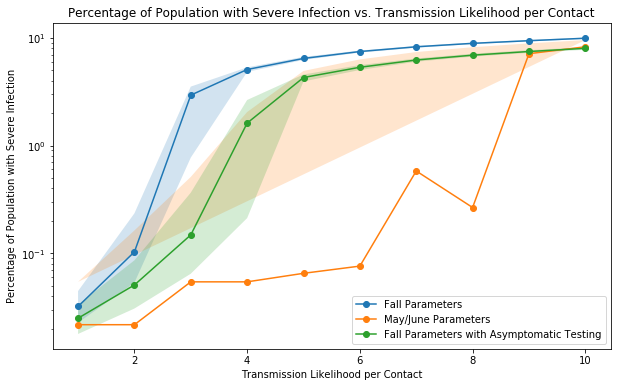

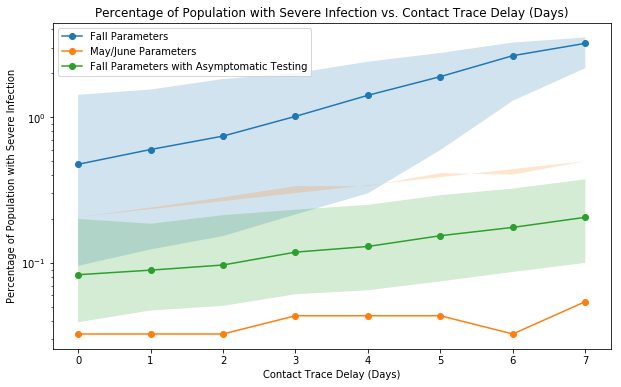

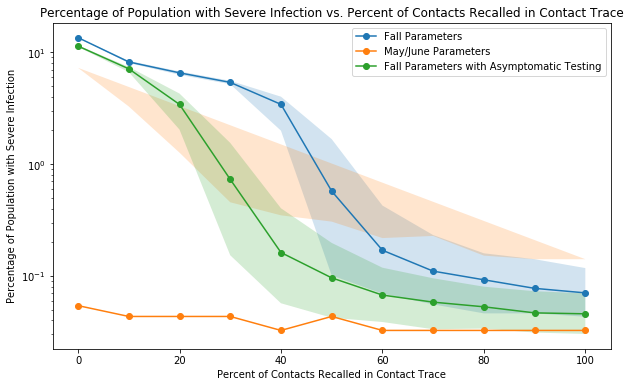

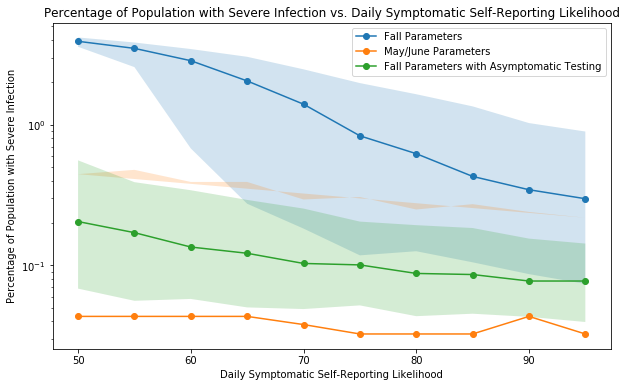

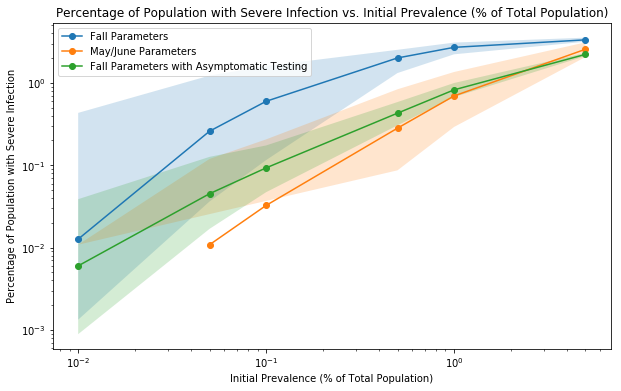

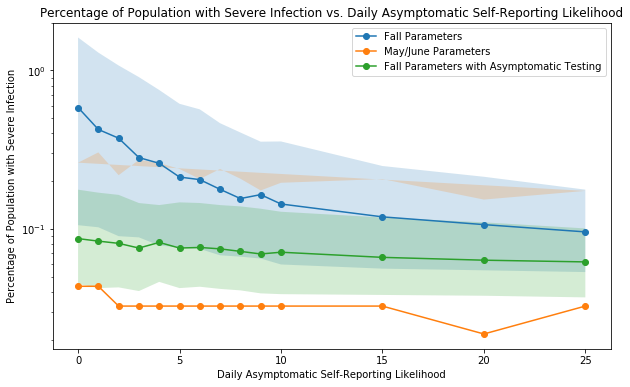

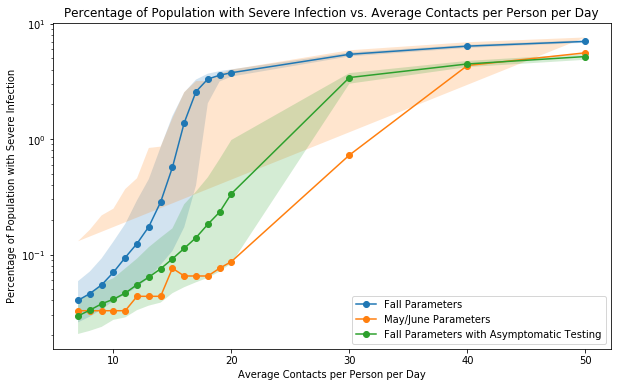

In [53]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs_quantiles({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, cum_severe_quantiles,
                            normalize_params[sim_name], x_log_scale=plot_log_scale[sim_name],
                 xlabel=plot_labels[sim_name], ylabel="Percentage of Population with Severe Infection",
                 title="Percentage of Population with Severe Infection vs. {}".format(plot_labels[sim_name]), 
                           q_low=0.1, q_high=0.9, alpha=0.2, y_min = 0, y_max=5, y_log_scale=True)

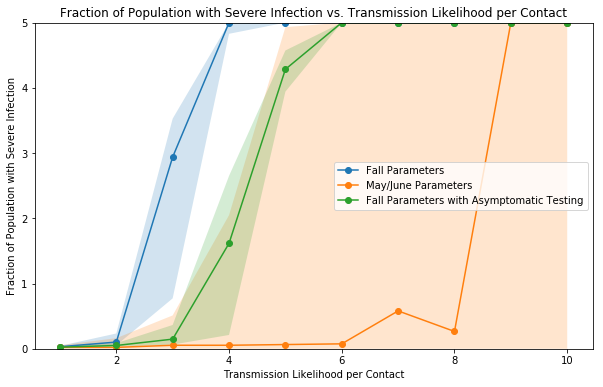

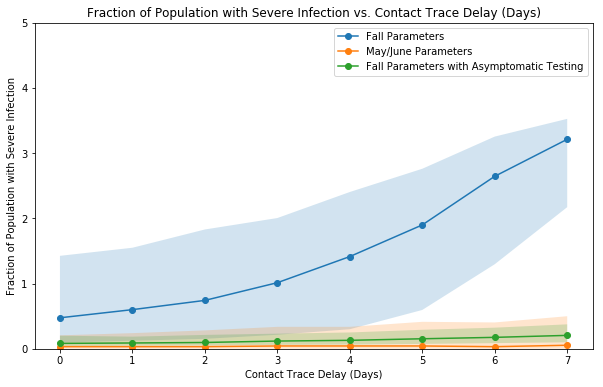

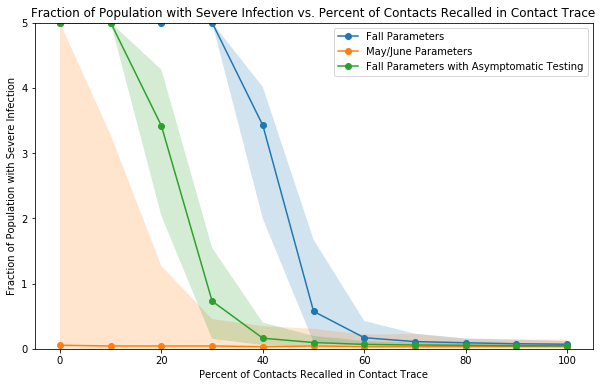

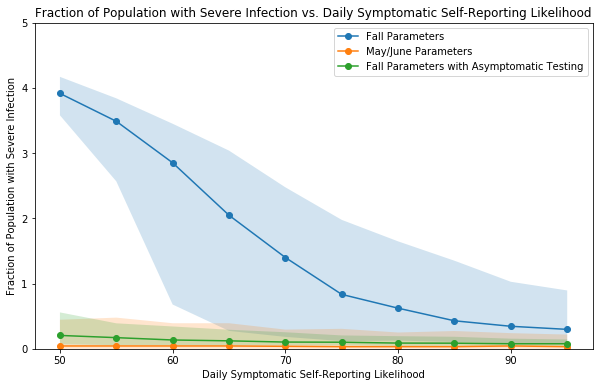

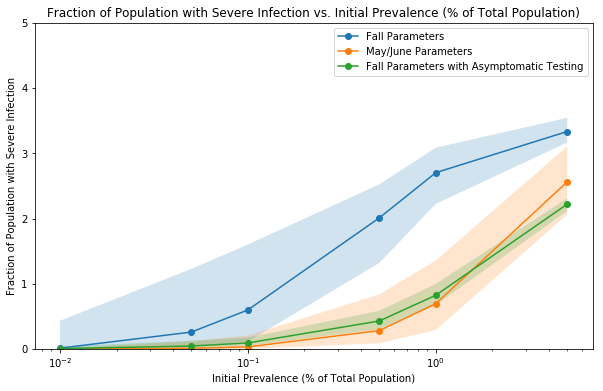

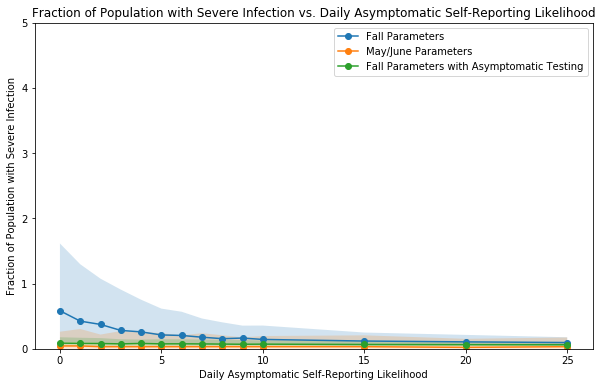

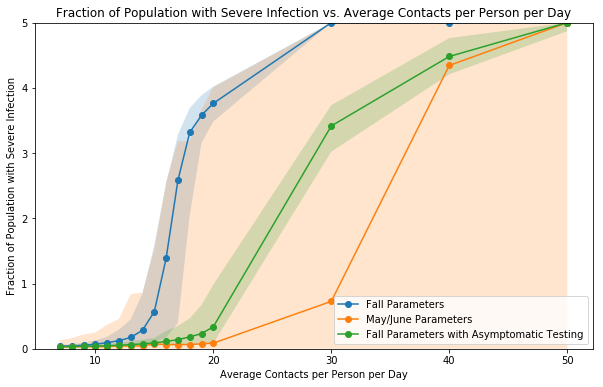

In [32]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs_quantiles({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, cum_severe_quantiles,
                            normalize_params[sim_name], x_log_scale=plot_log_scale[sim_name],
                 xlabel=plot_labels[sim_name], ylabel="Percent of Population with Severe Infection",
                 title="Percent of Population with Severe Infection vs. {}".format(plot_labels[sim_name]), 
                           q_low=0.1, q_high=0.9, alpha=0.2)

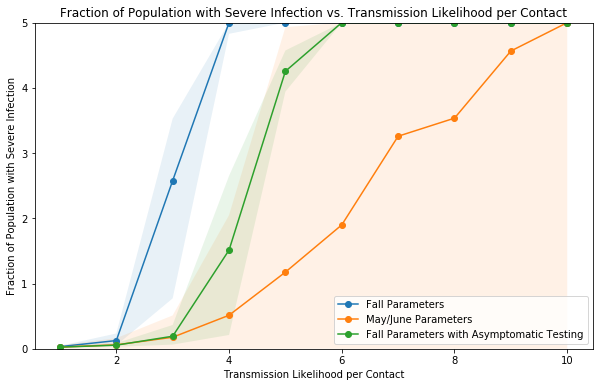

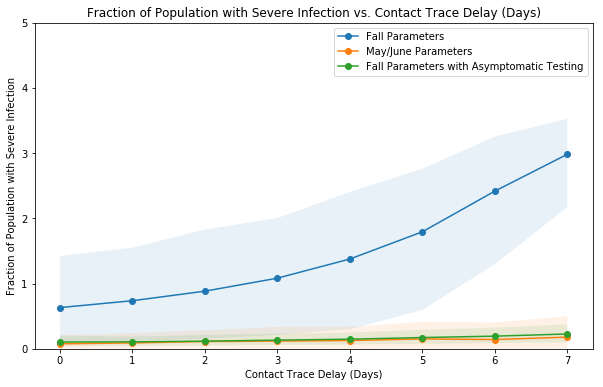

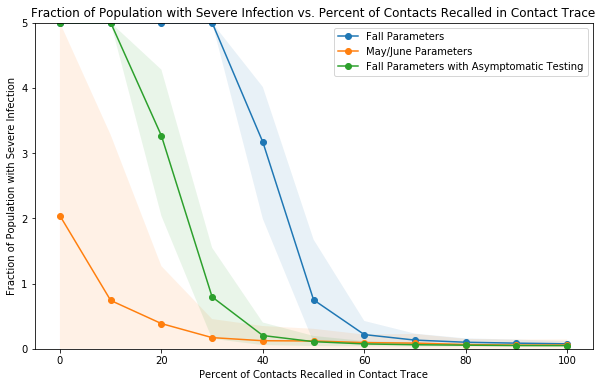

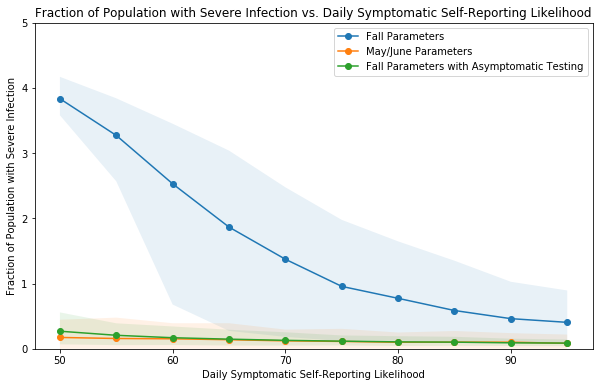

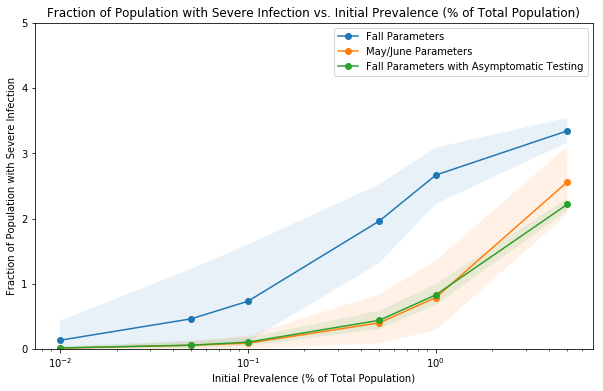

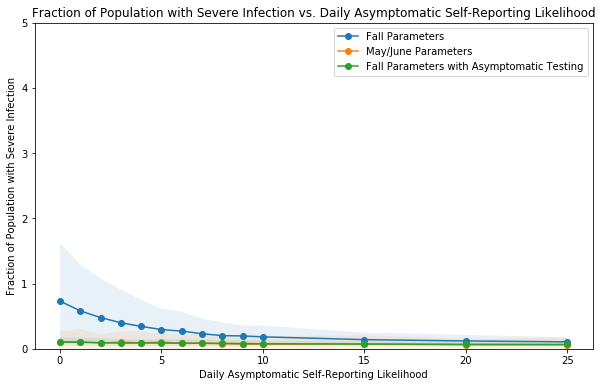

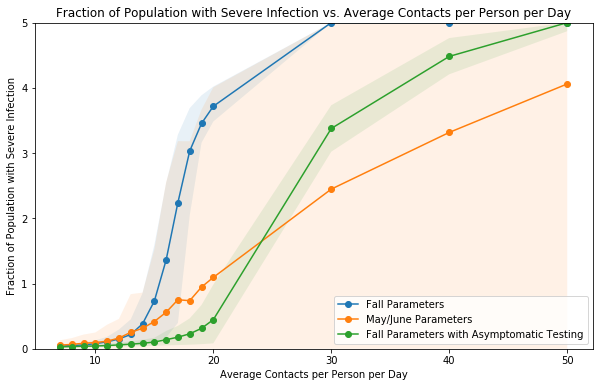

In [30]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs_quantiles({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, avg_cum_severe_quantile,
                            normalize_params[sim_name], x_log_scale=plot_log_scale[sim_name],
                 xlabel=plot_labels[sim_name], ylabel="Fraction of Population with Severe Infection",
                 title="Fraction of Population with Severe Infection vs. {}".format(plot_labels[sim_name]), 
                           q_low=0.1, q_high=0.9)

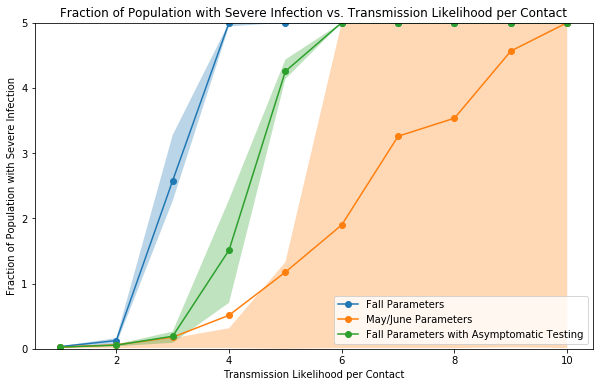

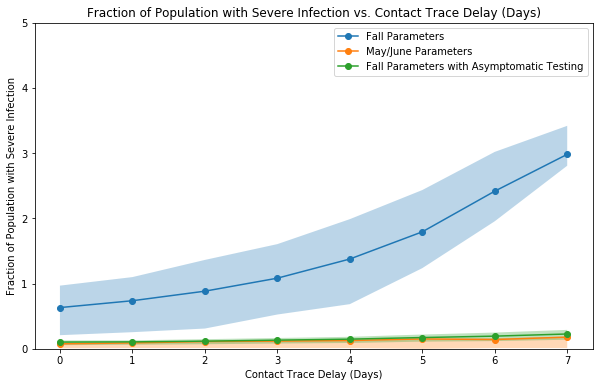

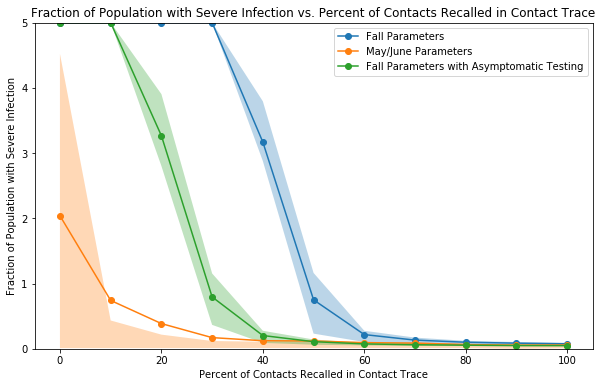

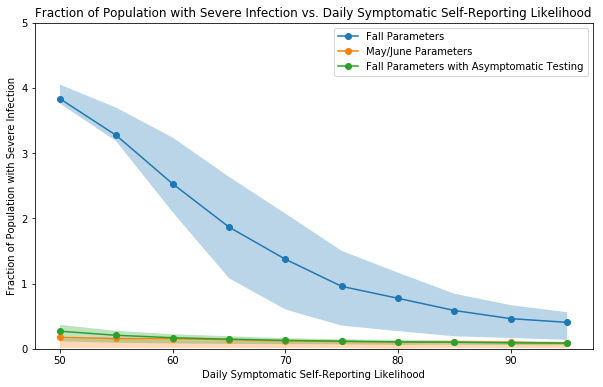

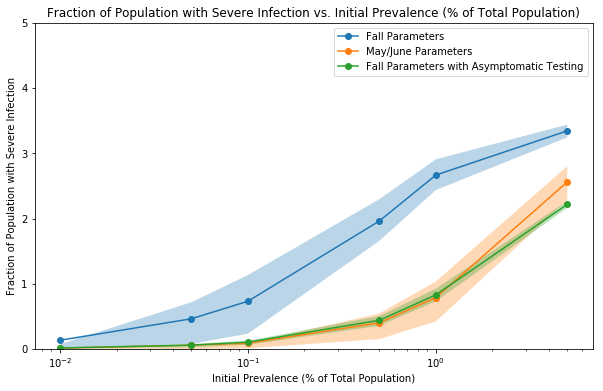

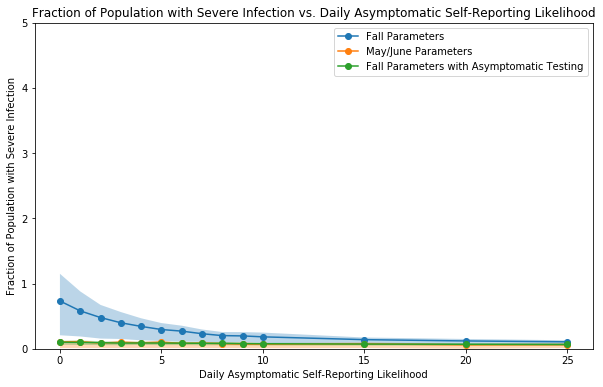

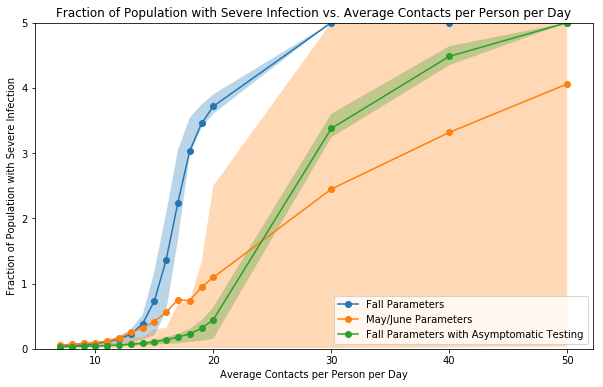

In [28]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs_quantiles({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, avg_cum_severe_quantile,
                            normalize_params[sim_name], x_log_scale=plot_log_scale[sim_name],
                 xlabel=plot_labels[sim_name], ylabel="Fraction of Population with Severe Infection",
                 title="Fraction of Population with Severe Infection vs. {}".format(plot_labels[sim_name]), 
                           q_low=0.25, q_high=0.75)

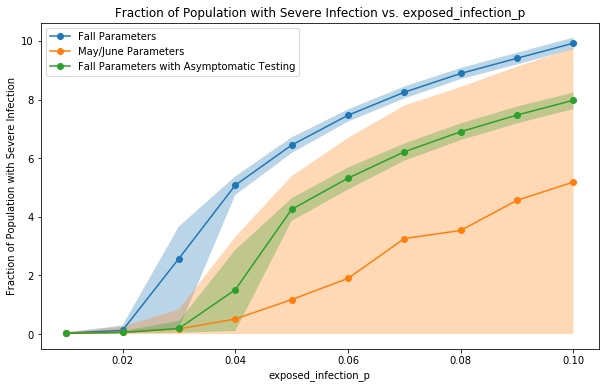

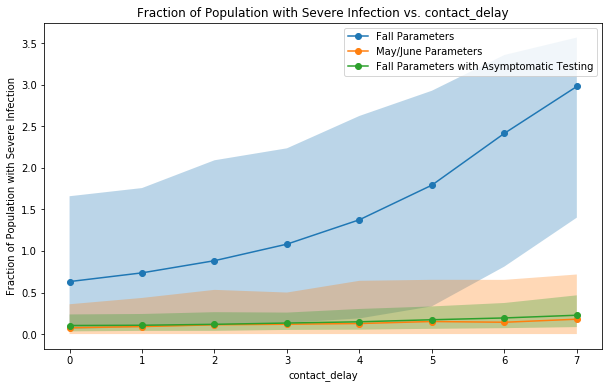

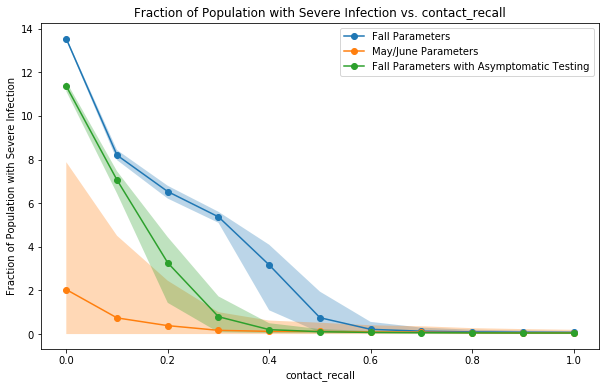

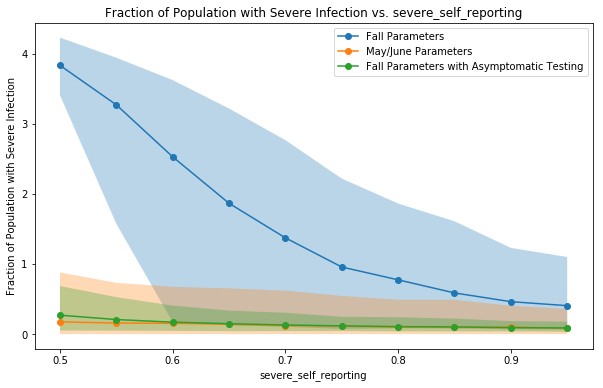

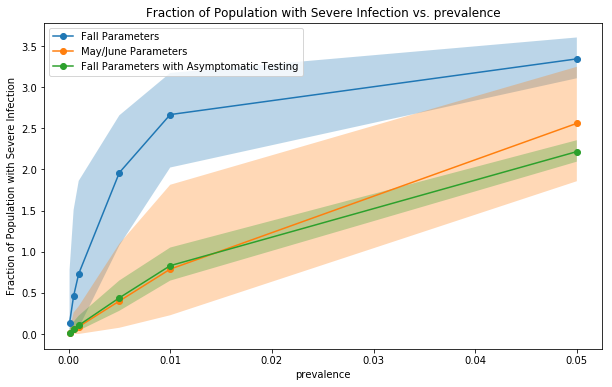

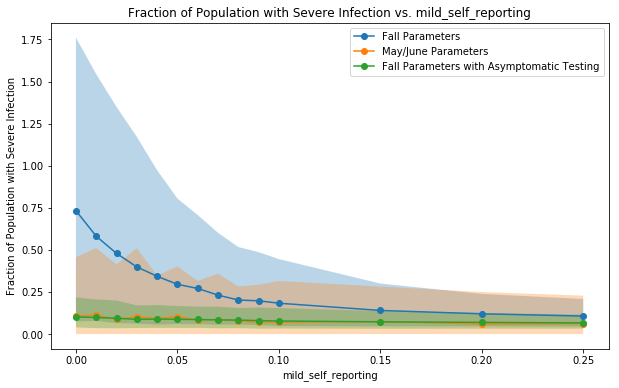

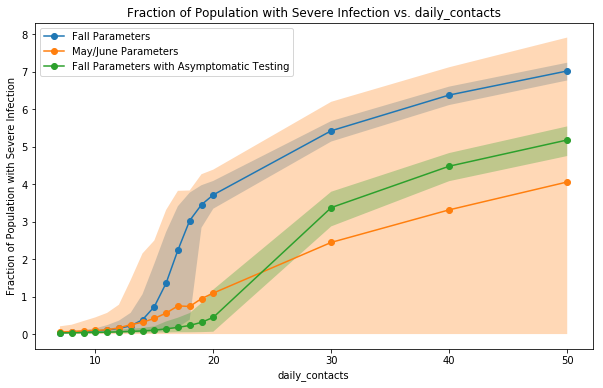

In [15]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs_quantiles({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, avg_cum_severe_quantile,
                            normalize_params[sim_name],
                 xlabel=plot_labels[sim_name], ylabel="Fraction of Population with Severe Infection",
                 title="Fraction of Population with Severe Infection vs. {}".format(plot_labels[sim_name]))

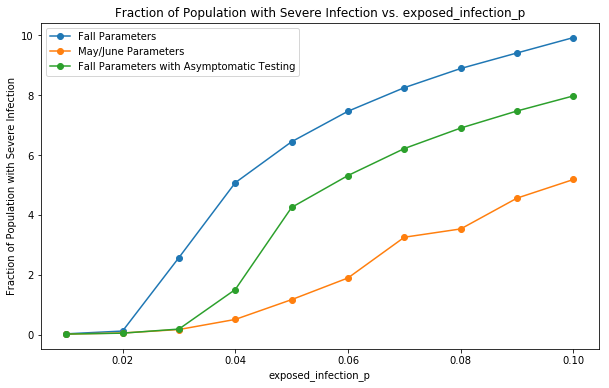

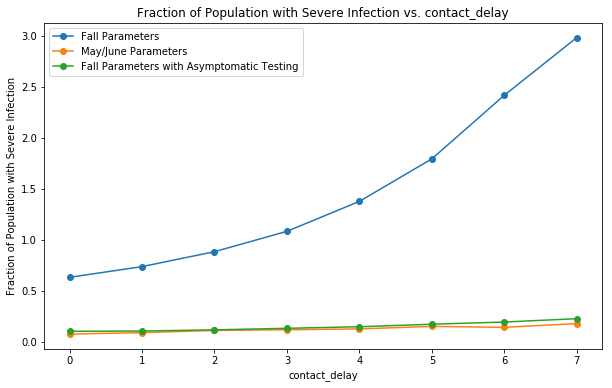

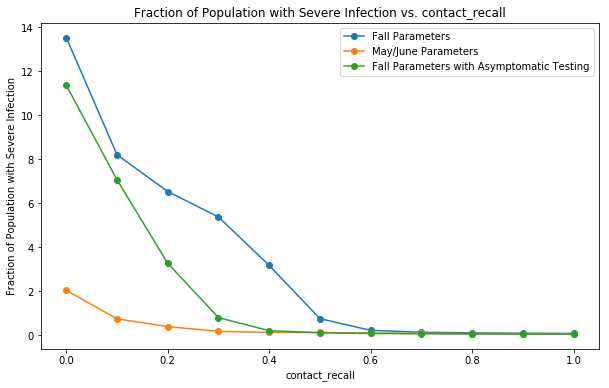

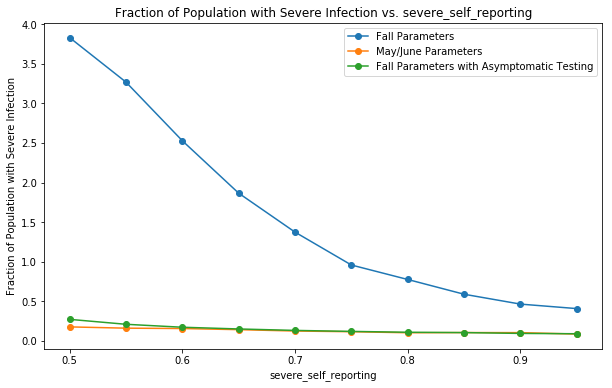

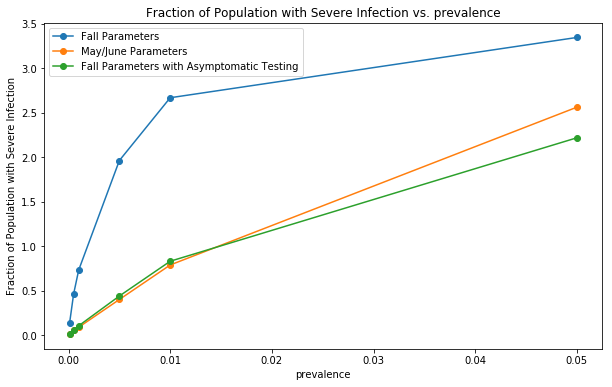

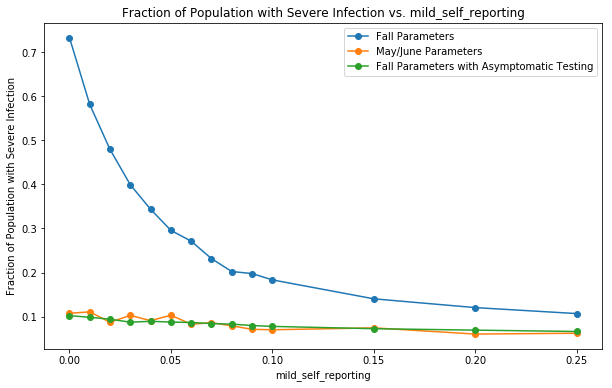

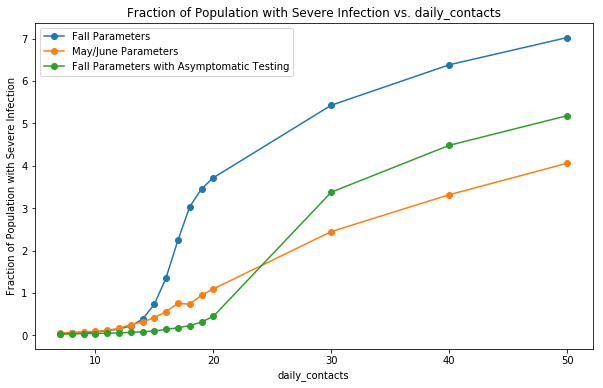

In [9]:
sim_names = set(fall_sim_results.keys())
for sim_name in sim_names:
    fall_dfs = fall_sim_results[sim_name]
    base_dfs = base_sim_results[sim_name]
    fall_testing_dfs = fall_testing_results[sim_name]
    plot_many_dfs({'Fall Parameters': fall_dfs, 'May/June Parameters': base_dfs, 
                   'Fall Parameters with Asymptomatic Testing': fall_testing_dfs}, average_cumulative_severe,
                 xlabel=sim_name, ylabel="Fraction of Population with Severe Infection",
                 title="Fraction of Population with Severe Infection vs. {}".format(sim_name))